In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

# Part 0: Code Extraction

In [3]:
!kaggle datasets download -d sudalairajkumar/cryptocurrencypricehistory

  0% 0.00/1.70M [00:00<?, ?B/s]
100% 1.70M/1.70M [00:00<00:00, 123MB/s]


In [4]:
!pwd

/content


In [5]:
!unzip "/content/cryptocurrencypricehistory.zip" -d "/content/data/"

Archive:  /content/cryptocurrencypricehistory.zip
  inflating: /content/data/coin_Aave.csv  
  inflating: /content/data/coin_BinanceCoin.csv  
  inflating: /content/data/coin_Bitcoin.csv  
  inflating: /content/data/coin_Cardano.csv  
  inflating: /content/data/coin_ChainLink.csv  
  inflating: /content/data/coin_Cosmos.csv  
  inflating: /content/data/coin_CryptocomCoin.csv  
  inflating: /content/data/coin_Dogecoin.csv  
  inflating: /content/data/coin_EOS.csv  
  inflating: /content/data/coin_Ethereum.csv  
  inflating: /content/data/coin_Iota.csv  
  inflating: /content/data/coin_Litecoin.csv  
  inflating: /content/data/coin_Monero.csv  
  inflating: /content/data/coin_NEM.csv  
  inflating: /content/data/coin_Polkadot.csv  
  inflating: /content/data/coin_Solana.csv  
  inflating: /content/data/coin_Stellar.csv  
  inflating: /content/data/coin_Tether.csv  
  inflating: /content/data/coin_Tron.csv  
  inflating: /content/data/coin_USDCoin.csv  
  inflating: /content/data/coin_Uni

In [6]:
directory = '/content/data'
crypto_data = {};
 
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    key = filename[5:-4]
    crypto_data[key] = pd.read_csv(f);
    crypto_data[key]['Date'] = crypto_data[key]['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))


We will only extract data from coins that were launched before 2019 in order to include just the bigger coins. Moreover, ensuring all datasets have the same number of rows makes calculating correlations easier.

In [7]:
crypto_data_2019 = {};
day_2019 = datetime(2019, 1, 1)

num_entries = len(crypto_data["Bitcoin"][crypto_data["Bitcoin"]['Date'] > day_2019])

for key in crypto_data.keys():
  old_df = crypto_data[key]
  new_df = old_df[old_df['Date'] > day_2019].reset_index()
  if (len(new_df) == num_entries):
    crypto_data_2019[key] = new_df

# Part 1: Exploratory Data Analysis

Luckily for us, the Kaggle data has already been pre-cleaned! So we can just go on to look at what the data looks like at first glance. First we are going to write functions to find the mean of a coin, standard deviation of coin, and correlation of two coins.

In [8]:
def correlation(coin_1, coin_2):
  coin_1_series = crypto_data_2019[coin_1]['Close']
  coin_2_series = crypto_data_2019[coin_2]['Close']
  return coin_1_series.corr(coin_2_series)
  
def covariance(coin_1, coin_2):
  coin_1_series = crypto_data_2019[coin_1]['Close']
  coin_2_series = crypto_data_2019[coin_2]['Close']
  return pearsonr(coin_1_series, coin_2_series)

def mean(coin_1):
  return crypto_data_2019[coin_1]['Close'].mean()

def std(coin_1):
  return crypto_data_2019[coin_1]['Close'].std()

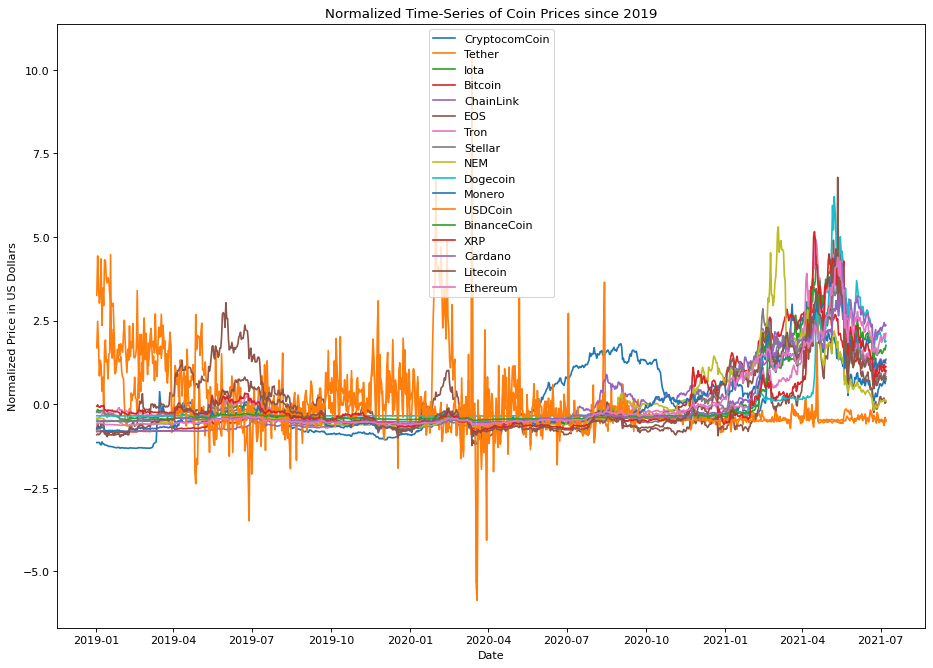

In [9]:
plt.figure(figsize=(14, 10), dpi=80)

for key in crypto_data_2019.keys():
  coin_mean = mean(key)
  coin_std = std(key)
  plt.plot(crypto_data_2019[key]['Date'], (crypto_data_2019[key]['Close'] - coin_mean)/coin_std, label=key)
  crypto_data_2019[key]['Normalized'] = (crypto_data_2019[key]['Close'] - coin_mean)/coin_std

plt.title("Normalized Time-Series of Coin Prices since 2019")
plt.ylabel("Normalized Price in US Dollars")
plt.xlabel("Date")

plt.legend()


We're also going to examine some pairwise graphs to see if prices are more closely correlated.

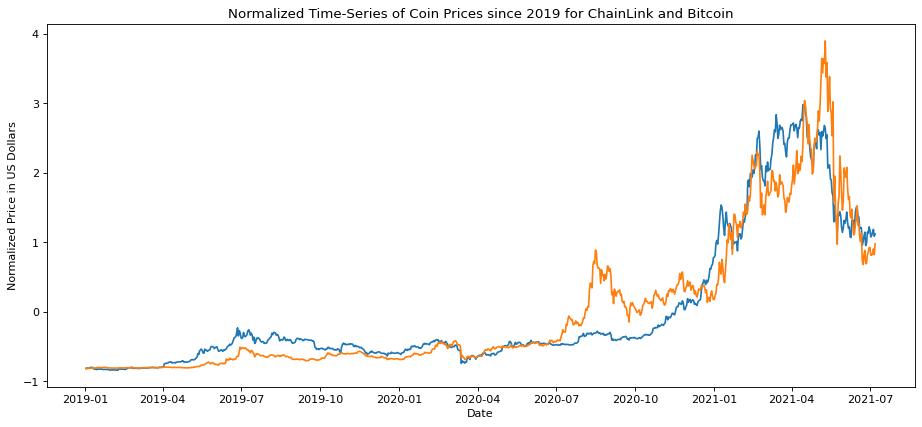

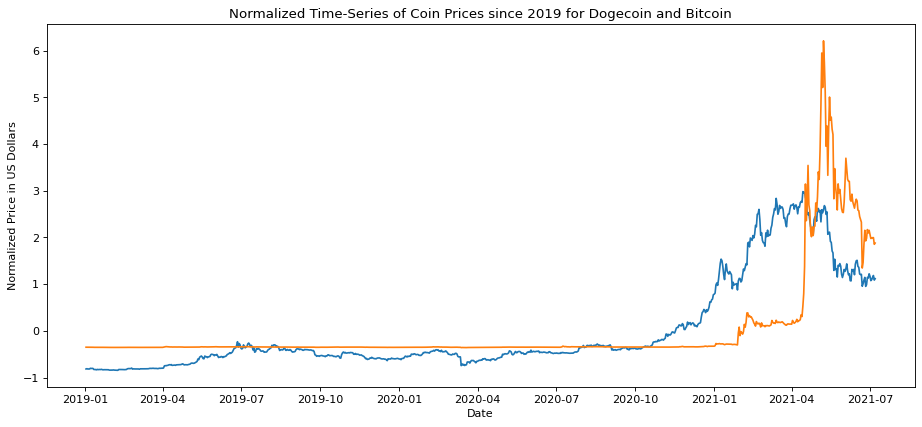

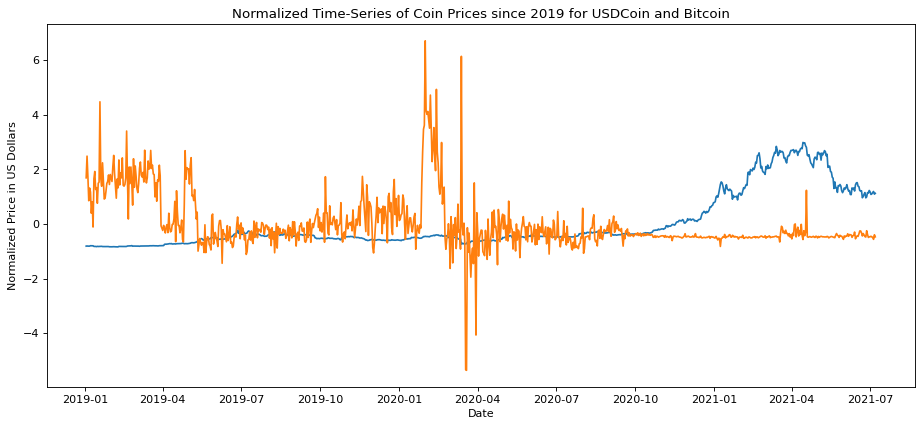

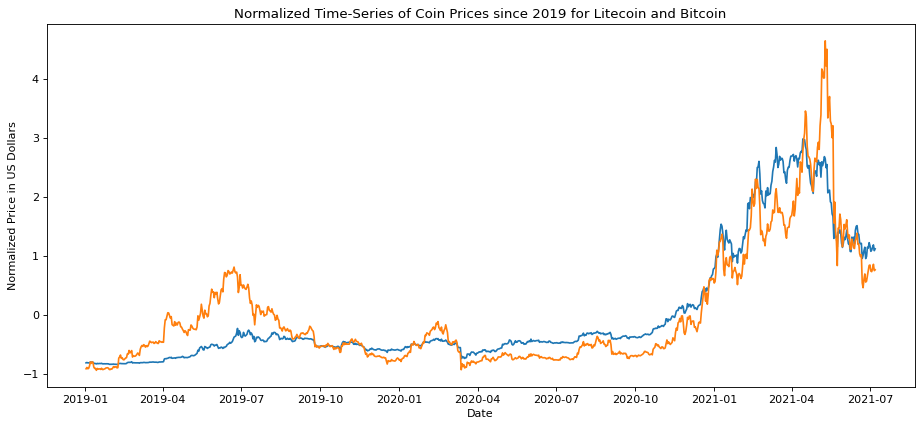

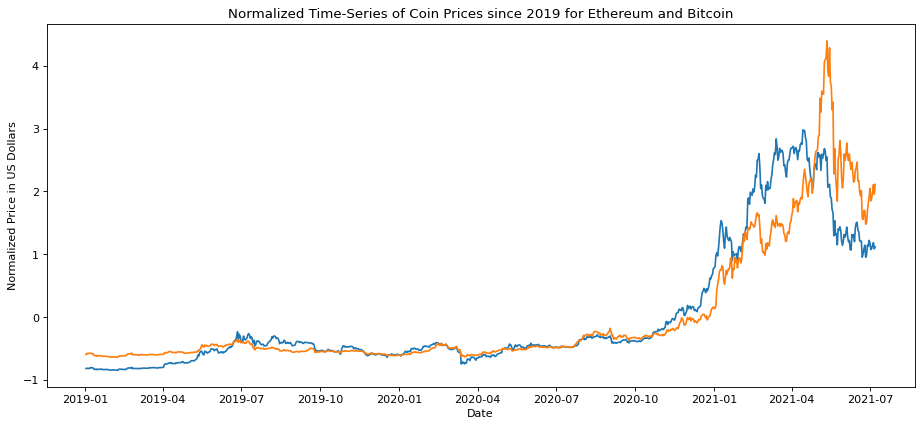

In [10]:
bitcoin_mean = mean("Bitcoin")
bitcoin_std = std("Bitcoin")


for key in crypto_data_2019.keys():
  if (key == "Ethereum" or key == "Litecoin" or key == "Dogecoin" or key == "USDCoin" or  key == "ChainLink"):
    coin_mean = mean(key)
    coin_std = std(key)
    plt.figure(figsize=(14, 6), dpi=80)
    plt.plot(crypto_data_2019['Bitcoin']['Date'], (crypto_data_2019['Bitcoin']['Close'] - bitcoin_mean)/bitcoin_std, label="Bitcoin")
    plt.plot(crypto_data_2019[key]['Date'], (crypto_data_2019[key]['Close'] - coin_mean)/coin_std, label=key)
    title = "Normalized Time-Series of Coin Prices since 2019 for " + key + " and Bitcoin"
    plt.title(title)
    plt.ylabel("Normalized Price in US Dollars")
    plt.xlabel("Date")
    plt.show()

Oops! We included some stable coins in our dataset. Let's remove them to ensure that we have only coins that we want! 

In [11]:
crypto_data_2019.pop("Tether")
crypto_data_2019.pop("USDCoin")
print("Done Dropping")

Done Dropping


Let's double check to ensure there are no NaN values in any of our 'Close' columns

In [12]:
for i in crypto_data_2019.keys():
  hasNan = crypto_data_2019['CryptocomCoin']['Close'].isnull().values.any()
  print("Coin", i, "has NaN values?  ", hasNan)


Coin CryptocomCoin has NaN values?   False
Coin Iota has NaN values?   False
Coin Bitcoin has NaN values?   False
Coin ChainLink has NaN values?   False
Coin EOS has NaN values?   False
Coin Tron has NaN values?   False
Coin Stellar has NaN values?   False
Coin NEM has NaN values?   False
Coin Dogecoin has NaN values?   False
Coin Monero has NaN values?   False
Coin BinanceCoin has NaN values?   False
Coin XRP has NaN values?   False
Coin Cardano has NaN values?   False
Coin Litecoin has NaN values?   False
Coin Ethereum has NaN values?   False


We're also going to see how correlated coins are with Bitcoin prices. This serves as a solid foundation on which we can compare our optimized value. The close the correlation is to 1, the more the two coins move together.

In [13]:
base_correlations = {}
standard_deviations = {}

for key in crypto_data_2019.keys():
  base_correlations[key] = correlation(key, "Bitcoin")
  standard_deviations[key] = std(key)

In [14]:
print(base_correlations)

{'CryptocomCoin': 0.664925126271156, 'Iota': 0.8999156658656329, 'Bitcoin': 0.9999999999999999, 'ChainLink': 0.94149192074957, 'EOS': 0.4393898330245415, 'Tron': 0.8303343342585211, 'Stellar': 0.9398659312171957, 'NEM': 0.8926982677228019, 'Dogecoin': 0.6425144676137503, 'Monero': 0.9173664266150153, 'BinanceCoin': 0.8509530527312476, 'XRP': 0.7417905524827522, 'Cardano': 0.8815147164115392, 'Litecoin': 0.9093782120879955, 'Ethereum': 0.91130746415225}


# Part 2: Determining Lag Time

We'll first write a function to determine the correlation between Bitcoin and another cryptocurrency given a lag time

In [15]:
def correlation_with_lag(coin, lag):
  coin_1_series = crypto_data_2019[coin].loc[lag:, 'Close'].reset_index(drop=True)
  bitcoin_series = crypto_data_2019['Bitcoin'].loc[:(len(crypto_data_2019['Bitcoin'].index) - lag - 1), 'Close'].reset_index(drop=True)
  return coin_1_series.corr(bitcoin_series)

Using the function we defined above, we then create a function that determines the optimal lag for a particular coin

In [16]:
def optimal_lag(coin, max_lag):
  optimal_value = 0
  optimal_corr = correlation(coin, 'Bitcoin')
  for lag in range(1, max_lag + 1):
    corr = correlation_with_lag(coin, lag)
    if corr > optimal_corr:
      optimal_value = lag
      optimal_corr = corr
  return optimal_value

We then construct a dictionary containing the optimal lag for each of our coins, setting ```max_lag``` to 100, as it's unlikely that an altcoin would take more than 100 days to follow Bitcoin



In [17]:
optimal_lags = {}
for coin in crypto_data_2019.keys():
  optimal_lags[coin] = optimal_lag(coin, 100)

In [18]:
print(optimal_lags)

{'CryptocomCoin': 3, 'Iota': 30, 'Bitcoin': 0, 'ChainLink': 2, 'EOS': 31, 'Tron': 31, 'Stellar': 4, 'NEM': 0, 'Dogecoin': 58, 'Monero': 30, 'BinanceCoin': 50, 'XRP': 33, 'Cardano': 50, 'Litecoin': 2, 'Ethereum': 31}


# Part 3: Analysis & Conclusions

Let's now take a look at our final data and analyze it

Text(0.5, 0, 'Coin')

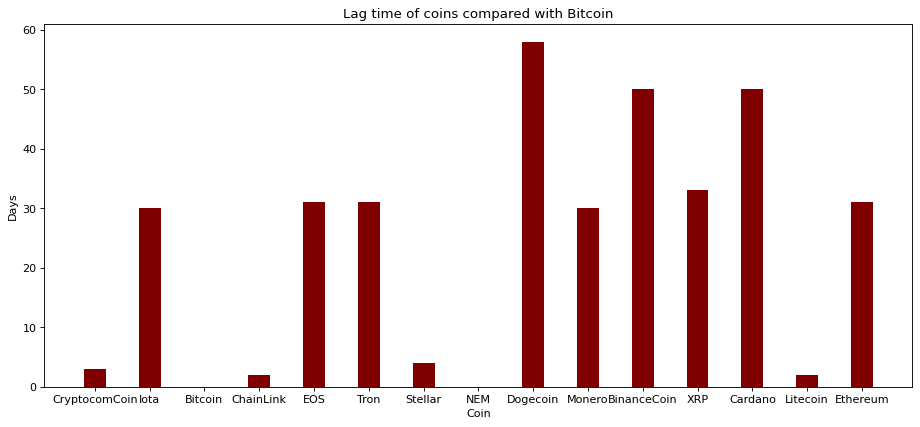

In [19]:
plt.figure(figsize=(14, 6), dpi=80)
plt.bar(optimal_lags.keys(), optimal_lags.values(), color ='maroon',
        width = 0.4)
plt.title('Lag time of coins compared with Bitcoin')
plt.ylabel("Days")
plt.xlabel("Coin")

This bar chart gives us an overview of each coins most correlated "lag time" compared with Bitcoins. In other words, the lag time is how much we "shift" the graph of the coin early to best correlate with Bitcoin. We are quite surprised about how large of a lag there is for a lot of these coins, especially for Dogecoin and Ethereum. So let's take a look at Ethereum and Dogecoin. We are interested in understanding why Dogecoin has such a high lag time, and Ethereum is generally a good measure when comparing bitcoin. 

We will also take a look at Litecoin and ChainLink, who had some of the lowest lags among the coins.

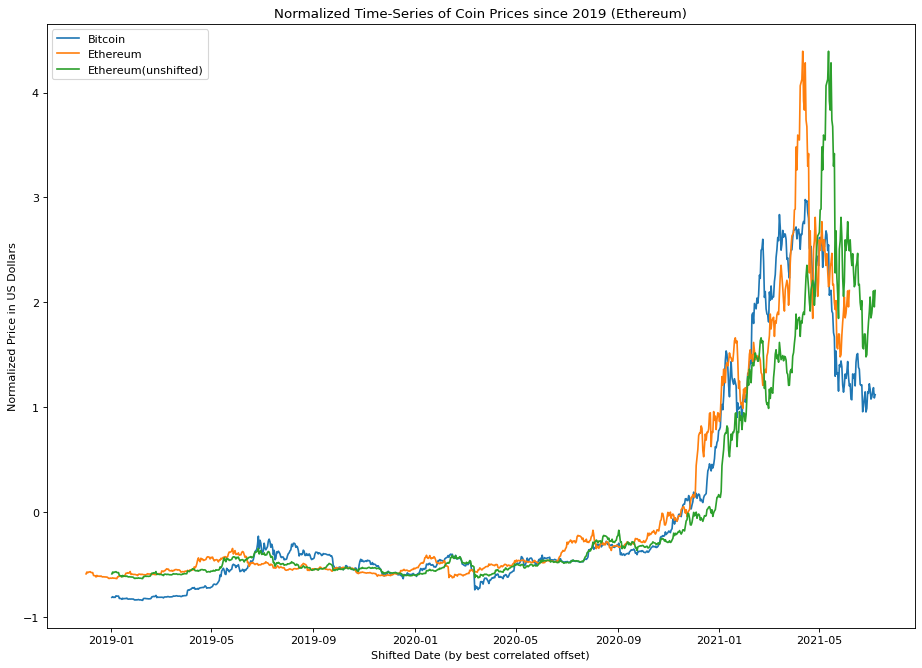

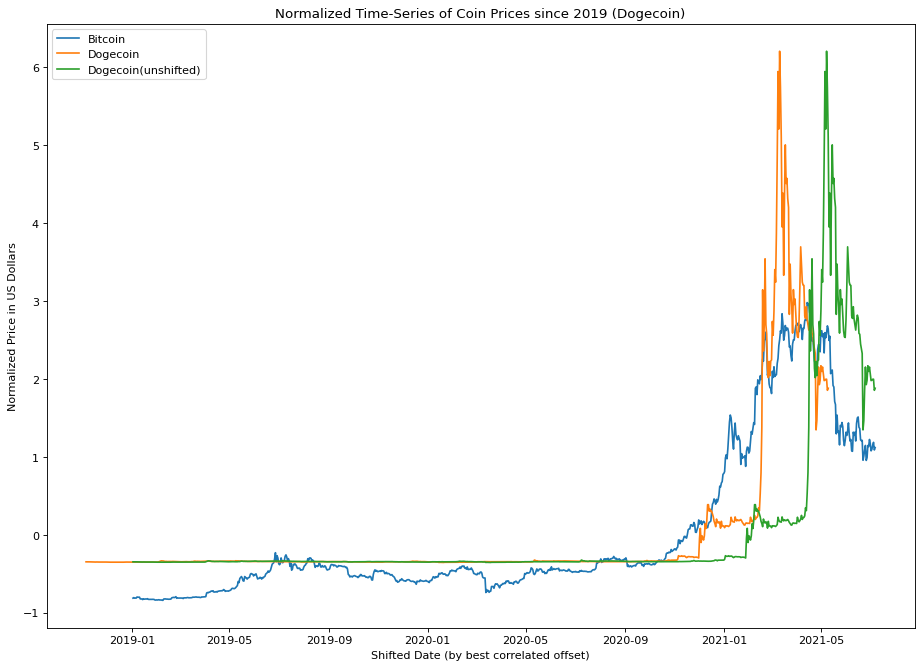

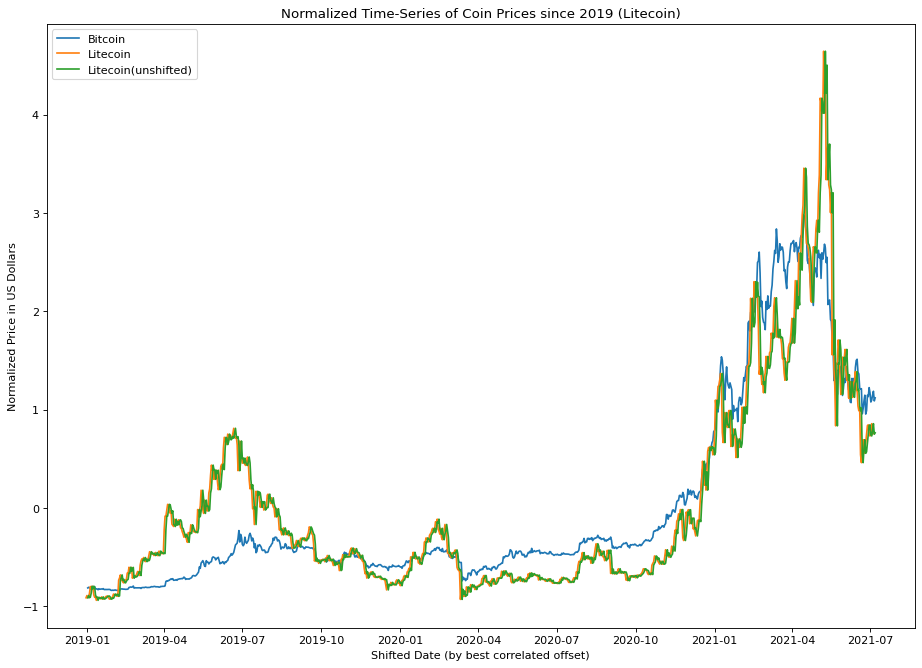

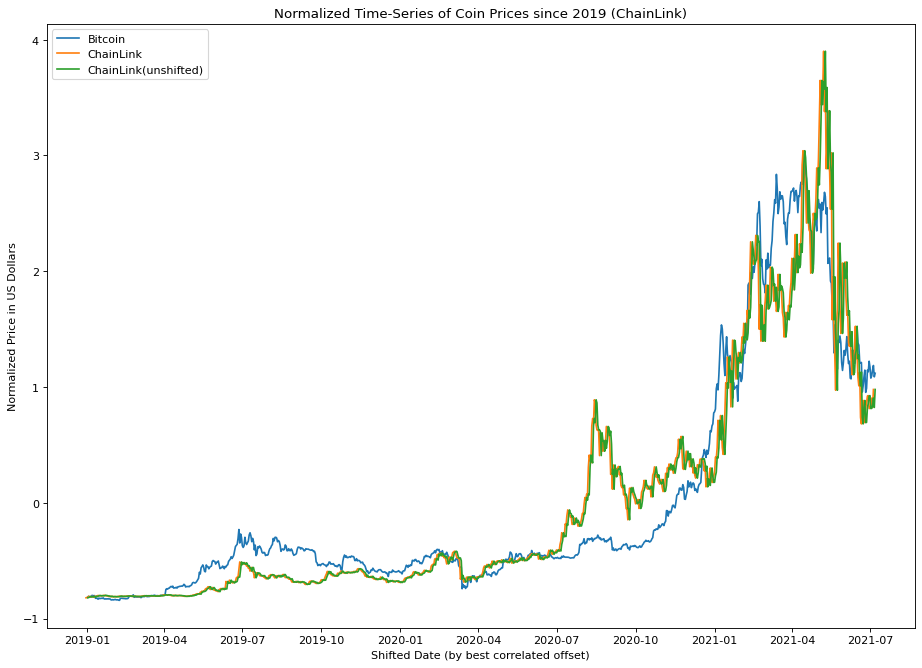

In [20]:
for compares in ['Ethereum', 'Dogecoin', 'Litecoin', 'ChainLink']:
  plt.figure(figsize=(14, 10), dpi=80)
  for key in ['Bitcoin', compares]:
    coin_mean = mean(key)
    coin_std = std(key)
    shiftedDates = crypto_data_2019[key]['Date'] - np.timedelta64(optimal_lags[key],'D')
    # print()
    plt.plot(shiftedDates, (crypto_data_2019[key]['Close'] - coin_mean)/coin_std, label=key)
    if(key != 'Bitcoin'):
          plt.plot(crypto_data_2019[key]['Date'], (crypto_data_2019[key]['Close'] - coin_mean)/coin_std, label=key + "(unshifted)")


    crypto_data_2019[key]['Normalized'] = (crypto_data_2019[key]['Close'] - coin_mean)/coin_std

  plt.title("Normalized Time-Series of Coin Prices since 2019 (" + compares + ")")
  plt.ylabel("Normalized Price in US Dollars")
  plt.xlabel("Shifted Date (by best correlated offset)")

  plt.legend()
  plt.show()


For both Ethereum and Dogecoin compared with Bitcoin prices, it seems the offset is shifted in order to best match the peaks together. Specifically, the Bitcoin peak of early 2021. It is also important to note the Dogecoin explosion that maybe wasn't directly incurred by change in Bitcoin prices. We think it is likely that this correlation is not a causation, and more about the "hype" surrounding Dogecoin as a "memecoin" after figures like Elon Musk tweeted about it.

Litecoin and Stellaris, though, were incredibly correlated with Bitcoin changes. We think Litecoin is quite correlated because of how similar the technology is with Bitcoin. Stellaris is a relatively smaller coin and thus may also be less independent as something like Ethereum.

In conclusion, our hypothesis that Bitcoin would have a very direct effect on coins was supported by only a few coins, specifically smaller coins and Bitcoin-related coins (like Litecoin). It seems that most of the larger coins such as Ethereum act independently of Bitcoin prices, and the high lag time is simply a peak-matching as they have similar rises/falls. We expected for our lag times to be at a much smaller scale, likely less than a week, so this came as a surprise to us.